In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image, ImageOps
from sklearn.metrics import classification_report
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

In [2]:
# Define empty lists to store image data and categories
data = []
categories = []
# Define the path to the image directory and load the metadata CSV file
mainDir = "C:\\Users\\DELL\\Desktop\\Machine\\"
path = mainDir + "images"
# load the dataset
meta = pd.read_csv(mainDir + "annotations.csv")
# Print the first 5 rows of the DataFrame to verify that it was loaded correctly
print(meta.head())

# Check for missing values
if meta.isnull().sum().sum() > 0:
    print('There are missing values in the dataset.')
else: 
    print('there are not missing values')

print(meta.dtypes)


# Check for duplicates in rows
if meta.duplicated().sum()>0:
    print('There are duplicate rows in the dataset.')
else:
    print('there are not duplicate rows in the dataset ')

# check for duplicate values in the 'Filename' column
duplicates = meta[meta.duplicated(['file_name'], keep=False)]

# print the duplicate values
print(f"There are {len(duplicates)} in the dataset")
# remove duplicate values in the 'Filename' column
meta = meta.drop_duplicates(subset=['file_name'], keep='first')

      file_name  width  height  x1  y1   x2   y2  category
0  000_0001.png    134     128  19   7  120  117         0
1  000_0002.png    165     151  23  12  149  138         0
2  000_0003.png    128     122  22  14  116  105         0
3  000_0010.png     80      73  14   8   67   63         0
4  000_0011.png    186     174  36  15  155  157         0
there are not missing values
file_name    object
width         int64
height        int64
x1            int64
y1            int64
x2            int64
y2            int64
category      int64
dtype: object
there are not duplicate rows in the dataset 
There are 332 in the dataset


In [3]:
# Get a list of all image filenames in the directory specified by 'path'.
images = os.listdir(path)
# Loop over each image and preprocess it
for x in images:
    # Open the image file and extract the crop coordinates from the metadata file
    image = Image.open(path + '\\' + x)
    x1 = meta.x1[meta.file_name == x].iloc[0]
    x2 = meta.x2[meta.file_name == x].iloc[0]
    y1 = meta.y1[meta.file_name == x].iloc[0]
    y2 = meta.y2[meta.file_name == x].iloc[0]
    # Crop and resize the image, and convert it to a NumPy array
    image = image.crop((x1,y1,x2,y2))
    image = image.resize((30,30))
    image = np.array(image)
    # Append the image data and category label to the corresponding lists
    data.append(image)
    categories.append(meta.category[meta.file_name == x].iloc[0])
 # This code creates NumPy arrays from the data and categories lists      
data = np.array(data)
categories = np.array(categories)
# Splitthe data into training and testing sets
x_train,x_test,y_train,y_test = train_test_split(data,categories,test_size = 0.3,random_state = 0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
# Convert the category labels to one-hot encoded vectors
y_train = to_categorical(y_train,58)
y_test = to_categorical(y_test,58)
# Normalize the pixel values of the input images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

(4198, 30, 30, 3)
(1800, 30, 30, 3)
(4198,)
(1800,)


In [4]:
CNN = mainDir + "CNN.h5"
ANN = mainDir + "ANN.h5"

In [5]:
# Check if a saved model exists, and load it if it does
if(os.path.exists(CNN)):
    CNNmodel = load_model(CNN)
  # Otherwise, create a new  cnn model and train it on the data  
else:
    CNNmodel = Sequential()
    CNNmodel.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu',input_shape=x_train.shape[1:]))
    CNNmodel.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu'))
    CNNmodel.add(MaxPool2D(pool_size=(2,2)))
    CNNmodel.add(Dropout(rate = 0.25))
    CNNmodel.add(Flatten())
    CNNmodel.add(Dense(256,activation='relu'))
    CNNmodel.add(Dropout(rate = 0.5))
    CNNmodel.add(Dense(58,activation='softmax'))
# Configure the model for training, specifying the loss function, optimizer, and evaluation metric
    CNNmodel.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# Train the model on the input data, specifying the training data, batch size, number of epochs, and validation data
    CNNmodel.fit(x_train,y_train,batch_size=32,epochs=8,validation_data=(x_test,y_test))
    # Save the trained model to a file
    CNNmodel.save(mainDir+"CNN.h5")

Epoch 1/8
132/132 [==============================] - 7s 46ms/step - loss: 1.7747 - accuracy: 0.5848 - val_loss: 0.5131 - val_accuracy: 0.8994
Epoch 2/8
132/132 [==============================] - 6s 44ms/step - loss: 0.4260 - accuracy: 0.8942 - val_loss: 0.1984 - val_accuracy: 0.9694
Epoch 3/8
132/132 [==============================] - 6s 45ms/step - loss: 0.2016 - accuracy: 0.9481 - val_loss: 0.1094 - val_accuracy: 0.9811
Epoch 4/8
132/132 [==============================] - 6s 44ms/step - loss: 0.1214 - accuracy: 0.9681 - val_loss: 0.0797 - val_accuracy: 0.9894
Epoch 5/8
132/132 [==============================] - 6s 44ms/step - loss: 0.0878 - accuracy: 0.9750 - val_loss: 0.0699 - val_accuracy: 0.9906
Epoch 6/8
132/132 [==============================] - 6s 46ms/step - loss: 0.0595 - accuracy: 0.9857 - val_loss: 0.0539 - val_accuracy: 0.9944
Epoch 7/8
132/132 [==============================] - 6s 45ms/step - loss: 0.0568 - accuracy: 0.9807 - val_loss: 0.0720 - val_accuracy: 0.9906
Epoch 

In [6]:
# Check if a saved  ann model exists, and load it if it does
if(os.path.exists(ANN)):
    ANNmodel = load_model(ANN)
  # Otherwise, create a new ann model and train it on the data  
else:
    ANNmodel = Sequential()
    ANNmodel.add(Flatten(input_shape=(30,30,3)))
    ANNmodel.add(Dense(128, activation='relu'))
    ANNmodel.add(Dense(64, activation='relu'))
    ANNmodel.add(Dense(58, activation='softmax'))
# Configure the model for training, specifying the loss function, optimizer, and evaluation metric
    ANNmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Train the model on the input data, specifying the training data and the number of epochs
    ANNmodel.fit(x_train, y_train, epochs=25)
    
    # Save the trained model to a file
    ANNmodel.save(mainDir+"ANN.h5")

Epoch 1/25
132/132 [==============================] - 1s 2ms/step - loss: 2.6029 - accuracy: 0.3911
Epoch 2/25
132/132 [==============================] - 0s 2ms/step - loss: 1.2399 - accuracy: 0.7253
Epoch 3/25
132/132 [==============================] - 0s 2ms/step - loss: 0.7926 - accuracy: 0.8130
Epoch 4/25
132/132 [==============================] - 0s 2ms/step - loss: 0.5658 - accuracy: 0.8580
Epoch 5/25
132/132 [==============================] - 0s 2ms/step - loss: 0.4675 - accuracy: 0.8821
Epoch 6/25
132/132 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.9200
Epoch 7/25
132/132 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.9307
Epoch 8/25
132/132 [==============================] - 0s 2ms/step - loss: 0.2203 - accuracy: 0.9483
Epoch 9/25
132/132 [==============================] - 0s 2ms/step - loss: 0.1693 - accuracy: 0.9624
Epoch 10/25
132/132 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.9683

In [7]:
# print the summary of the two models
print(CNNmodel.summary())
print(ANNmodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 256)               991488    
                                                        

In [8]:
# Get the actual labels from the test set
y_actual = np.argmax(y_test,axis=1)
# Make predictions using the trained CNN model on the test set
CNN_y_pred = CNNmodel.predict(x_test)
CNN_y_pred = np.argmax(CNN_y_pred,axis=1)
# Make predictions using the trained ANN model on the test set
ANN_y_pred = ANNmodel.predict(x_test)
ANN_y_pred = np.argmax(ANN_y_pred,axis=1)

57/57 [==============================] - 0s 819us/step


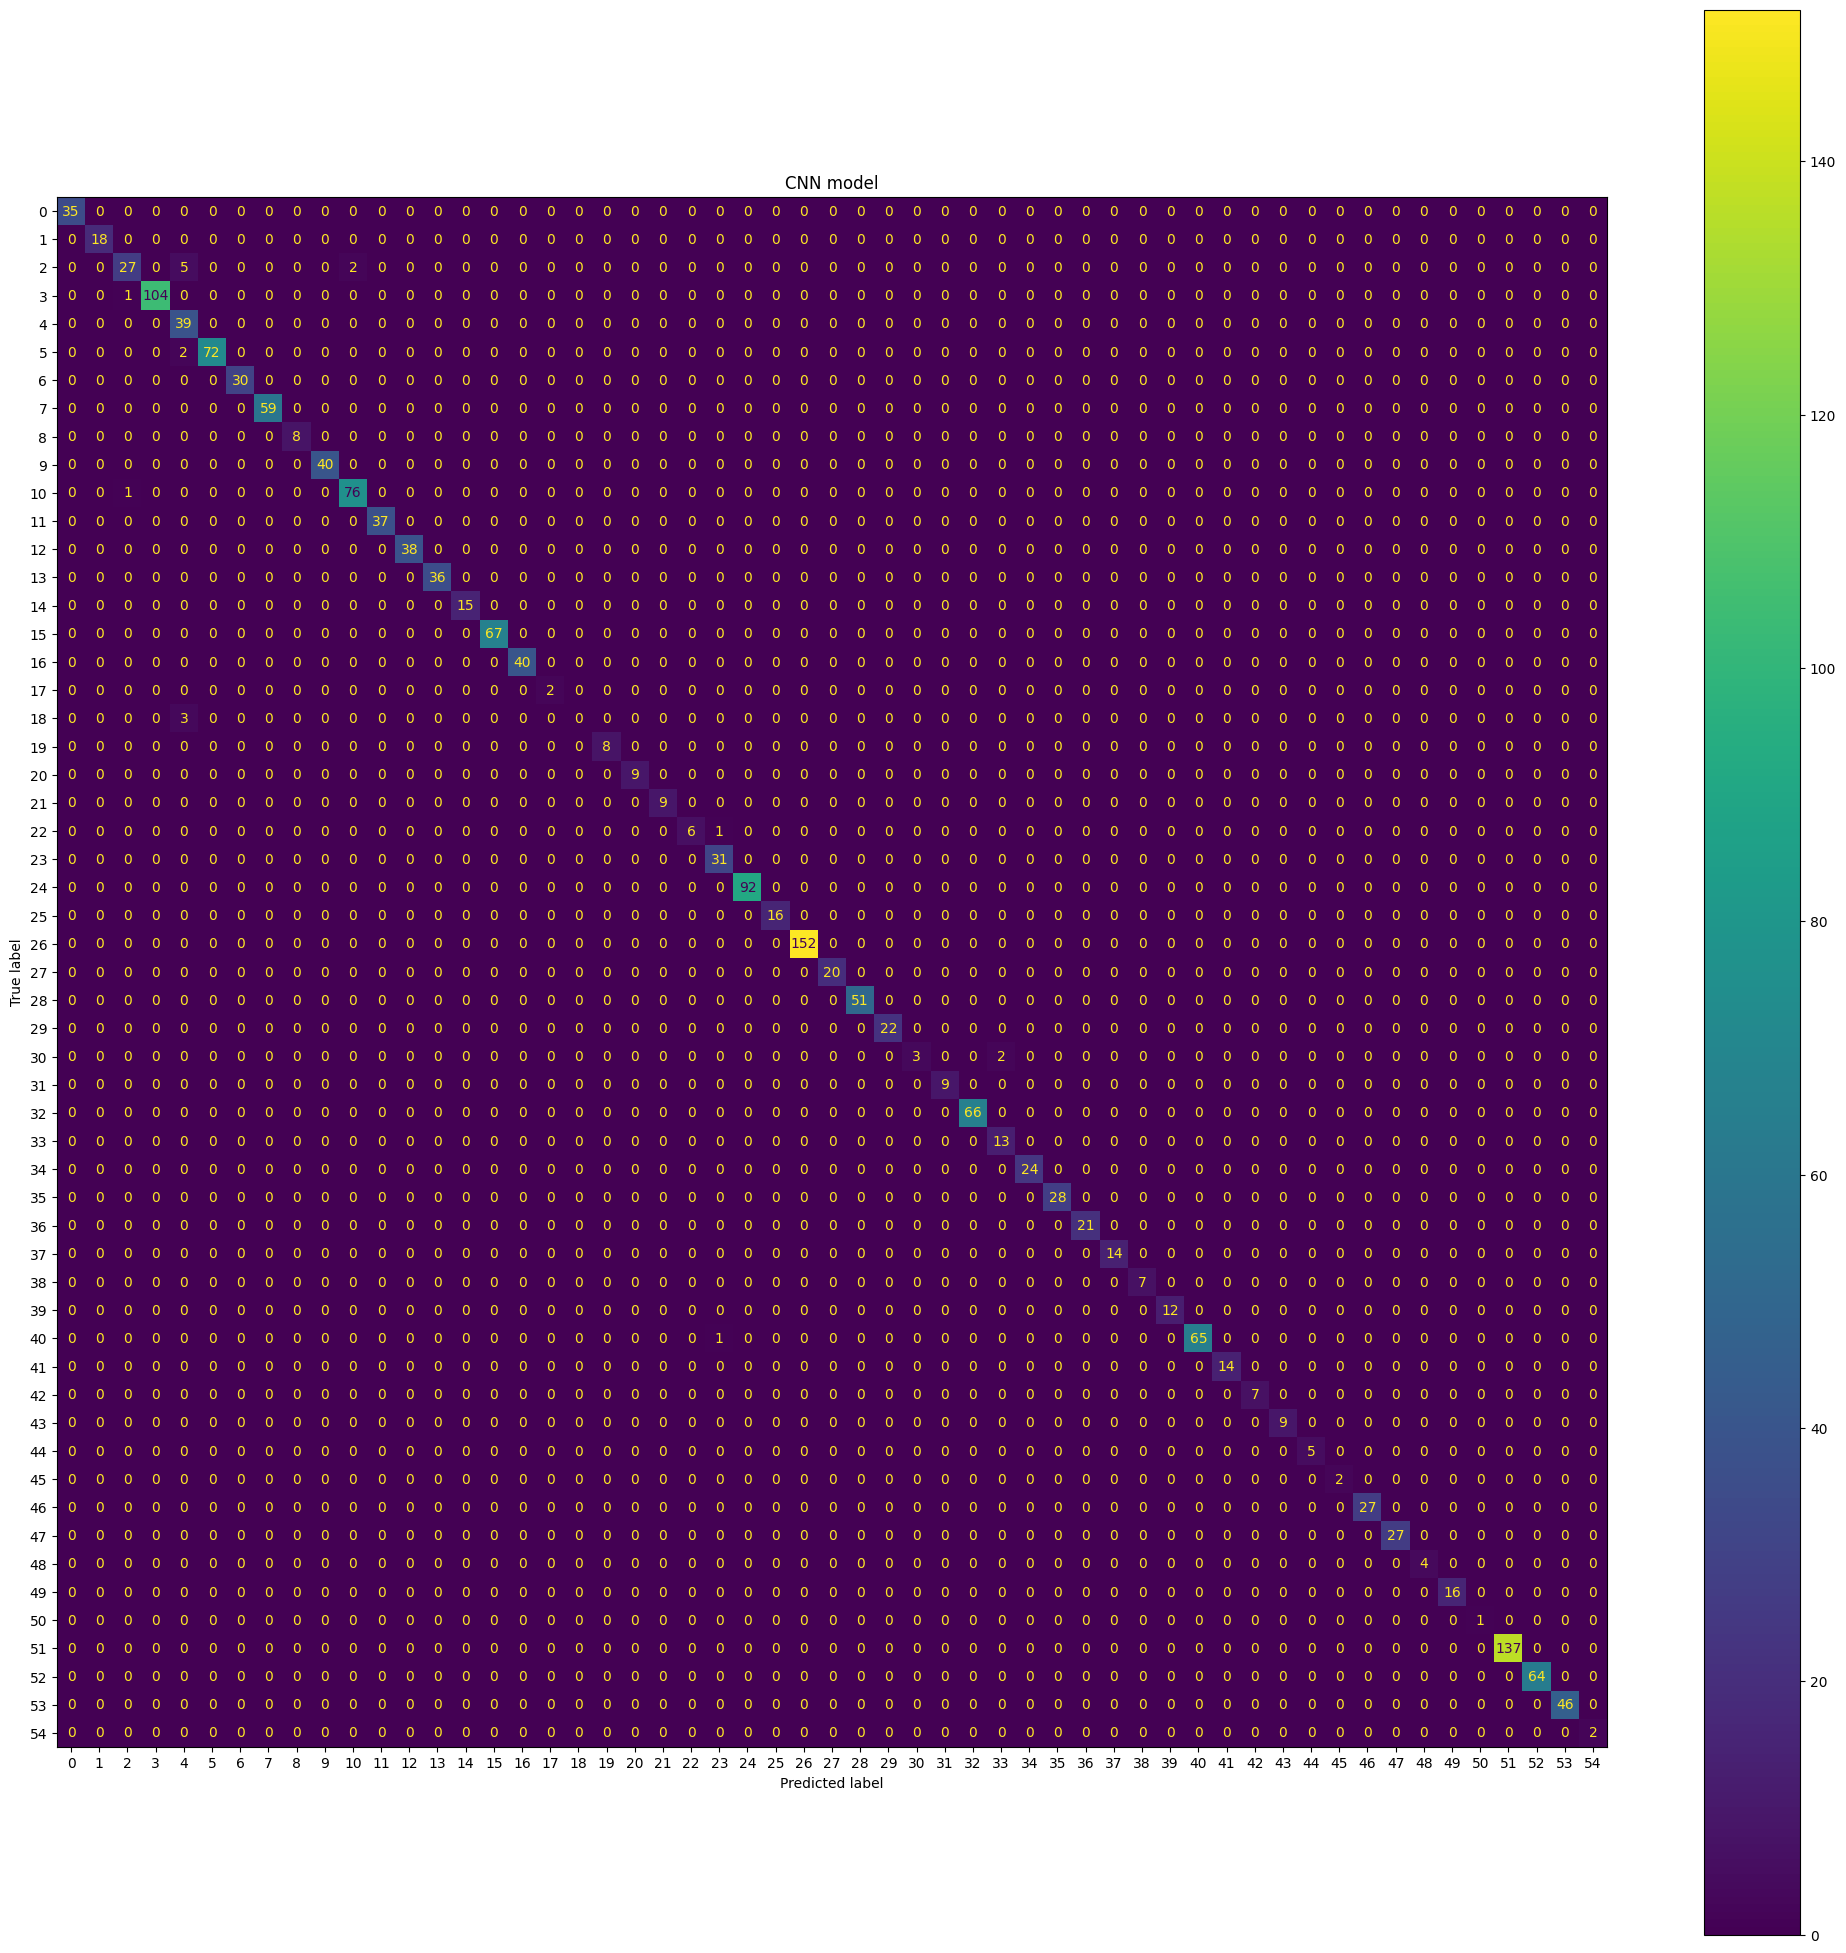

In [9]:
# Compute and plot the confusion matrix for the CNN model
CNN_CM = metrics.confusion_matrix(y_actual,CNN_y_pred)
figure,ax = plt.subplots(figsize=(25,25))
CNN_CMplot = metrics.ConfusionMatrixDisplay(CNN_CM)
CNN_CMplot.plot(ax=ax)
plt.title('CNN model')
plt.show()

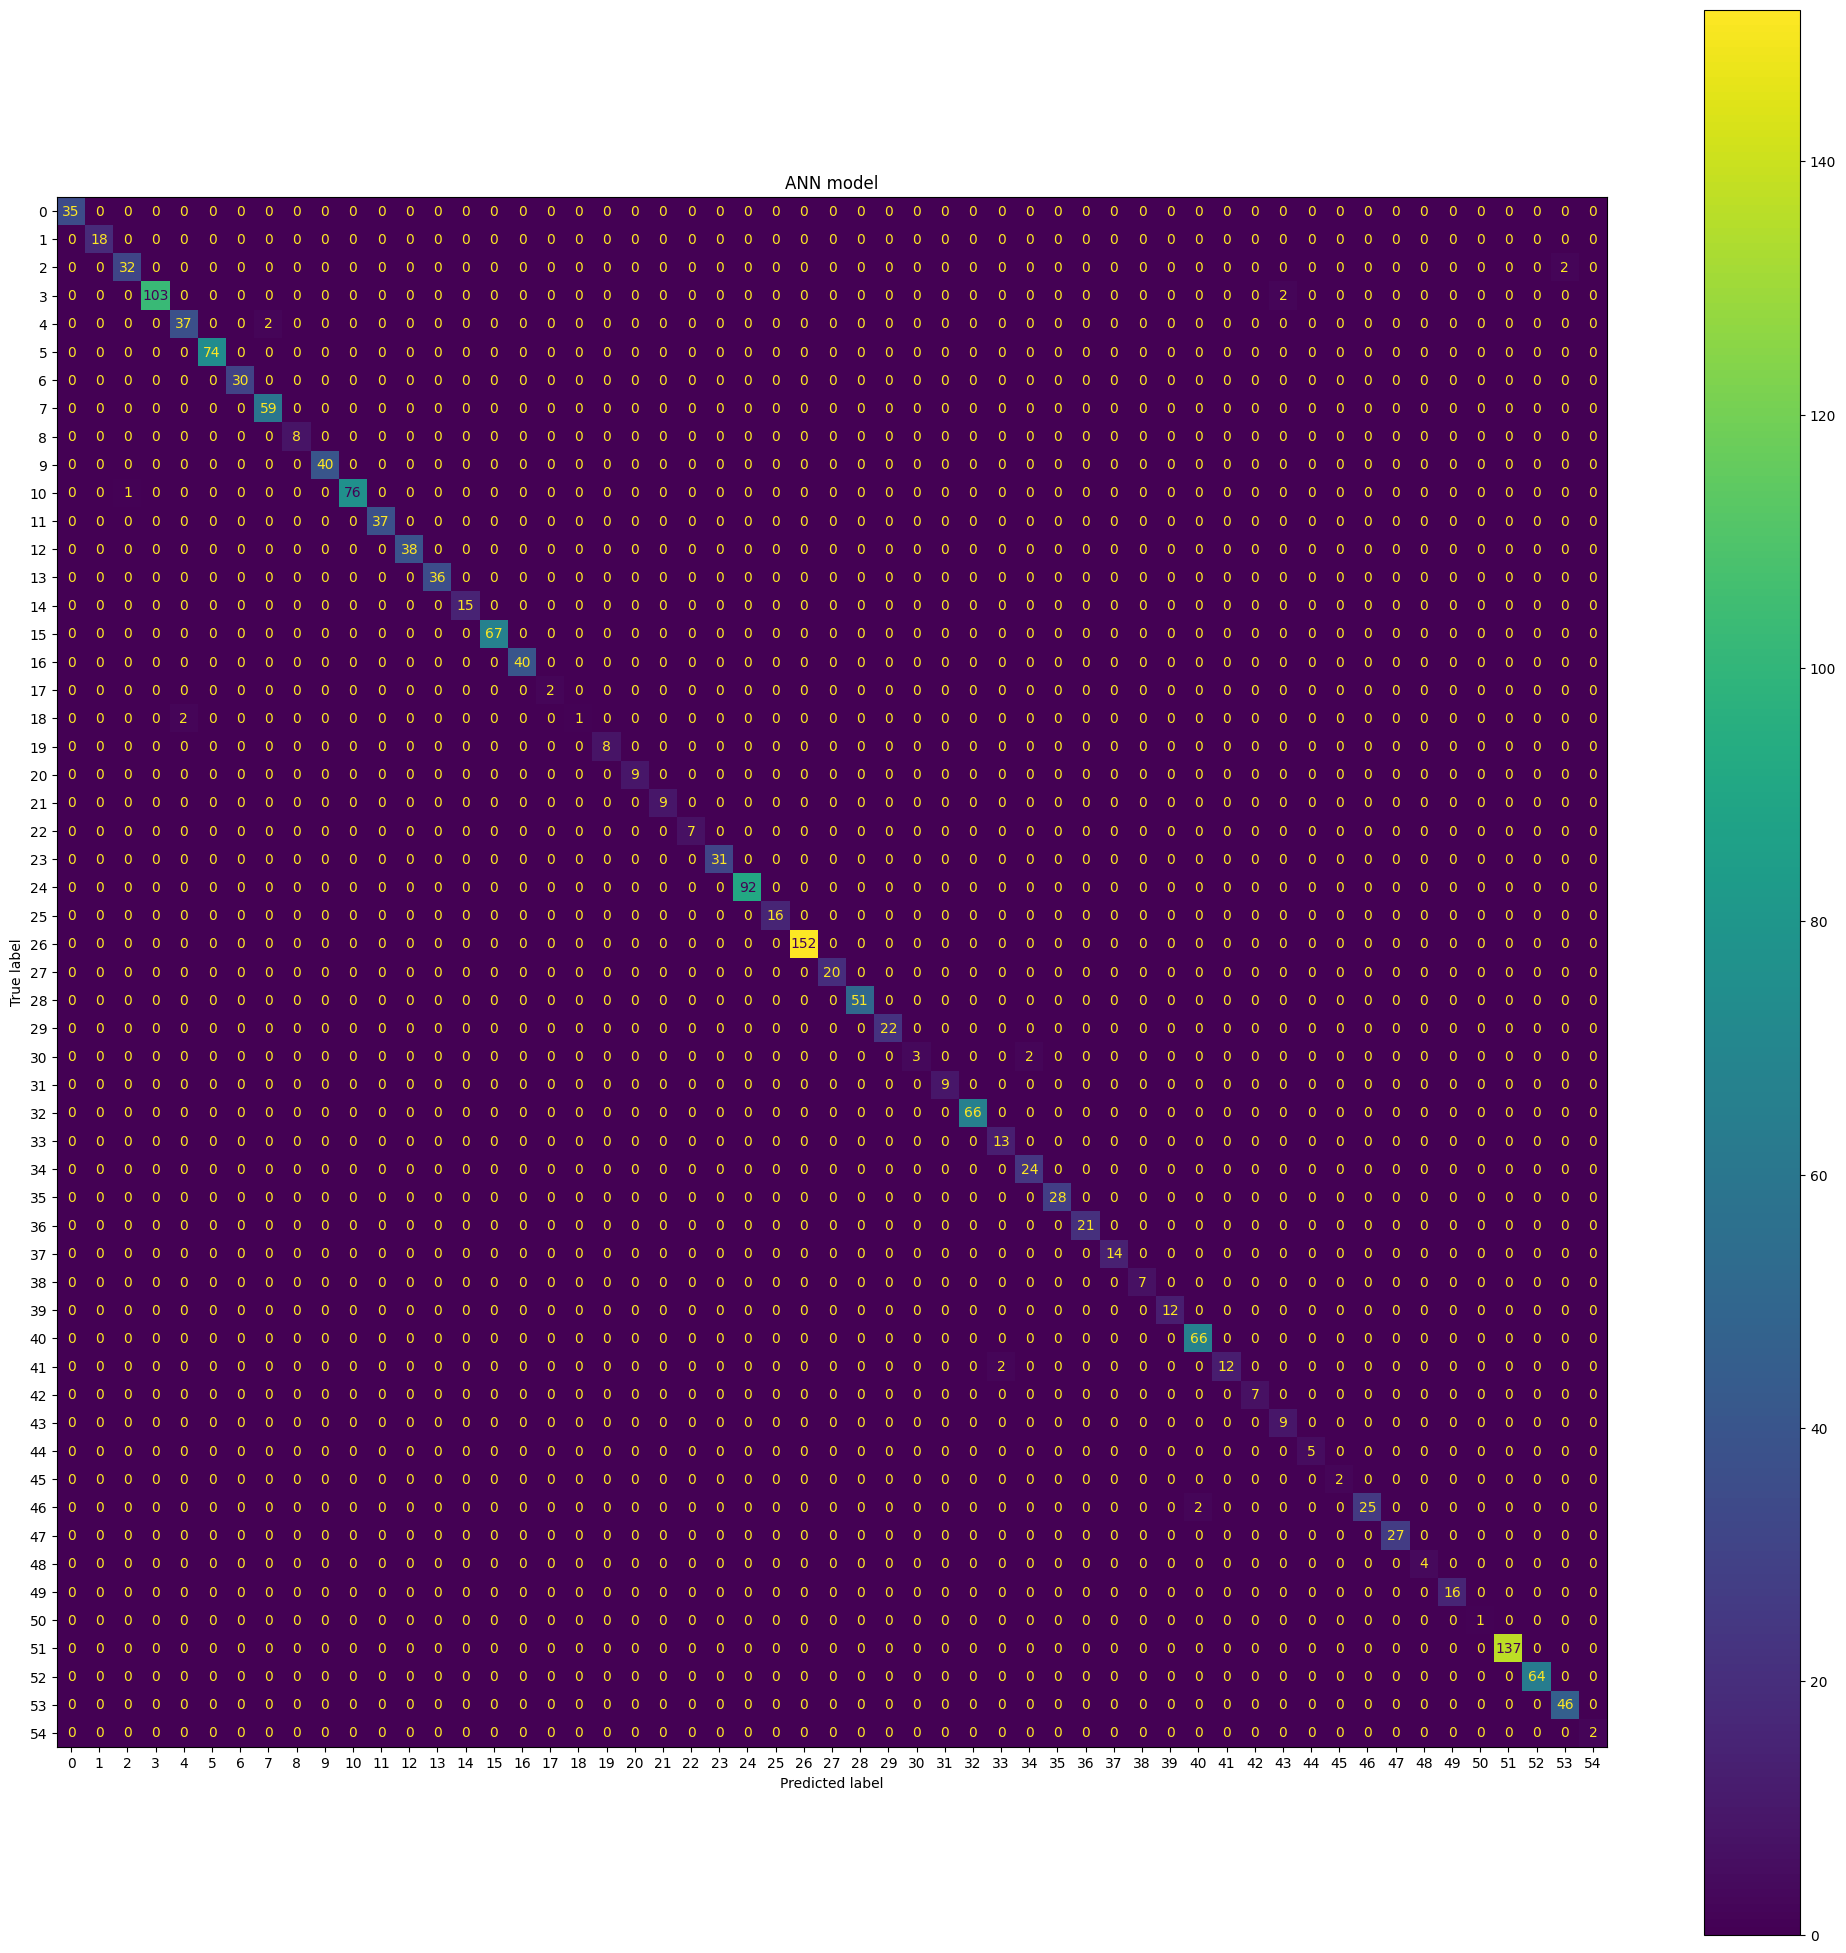

In [10]:
# Compute and plot the confusion matrix for the ANN model
ANN_CM = metrics.confusion_matrix(y_actual,ANN_y_pred)
figure,ax = plt.subplots(figsize=(25,25))
ANN_CMplot = metrics.ConfusionMatrixDisplay(ANN_CM)
ANN_CMplot.plot(ax=ax)
plt.title('ANN model')
plt.show()

In [11]:
# Print the classification report for the CNN model
print("CNN evaluation","-"*50)
print(classification_report(y_actual,CNN_y_pred))

CNN evaluation --------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        18
           2       0.93      0.79      0.86        34
           3       1.00      0.99      1.00       105
           4       0.80      1.00      0.89        39
           5       1.00      0.97      0.99        74
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        59
           8       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        40
          11       0.97      0.99      0.98        77
          12       1.00      1.00      1.00        37
          13       1.00      1.00      1.00        38
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        67
          17   

D:\Compilers\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Compilers\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Compilers\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Print the classification report for the ANN model
print("ANN evaluation","-"*50)
print(classification_report(y_actual,ANN_y_pred))

ANN evaluation --------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        18
           2       0.97      0.94      0.96        34
           3       1.00      0.98      0.99       105
           4       0.95      0.95      0.95        39
           5       1.00      1.00      1.00        74
           6       1.00      1.00      1.00        30
           7       0.97      1.00      0.98        59
           8       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        40
          11       1.00      0.99      0.99        77
          12       1.00      1.00      1.00        37
          13       1.00      1.00      1.00        38
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        67
          17   

In [14]:
# Load an image and preprocess it for input to the models
img = Image.open(r"C:\Users\DELL\Desktop\png-transparent-bicycle-cycling-segregated-cycle-facilities-traffic-sign-motorcycle-traffic-signs-blue-text-trademark-thumbnail.png")
img = img.convert("RGB")
img = img.resize((30,30))
img = np.array(img)
p = []
p.append(img)
p = np.array(p)
# Make predictions using the trained CNN and ANN models on the image
CNNout = np.argmax(CNNmodel.predict([p]))
ANNout = np.argmax(ANNmodel.predict([p]))
# Print the predicted categories for the image using the trained models
print(f'CNN: {CNNout}')
print(f'ANN: {ANNout}')
# Get the filenames for images with the predicted categories using the metadata dataframe, and display the images
CNNimageName = meta.file_name[meta.category == CNNout].iloc[0]
ANNimageName = meta.file_name[meta.category == ANNout].iloc[0]
Image.open(f"{path}\\{CNNimageName}").show()
Image.open(f"{path}\\{ANNimageName}").show()

1/1 [==============================] - 0s 16ms/step
CNN: 30
ANN: 30
